## **Author: Rambod Azimi**

## ORPO (Odds-Ratio Policy Optimization)

*   A fine-tuning technique to improve the adaptability of LLMs to specific tasks by addressing limitations in traditional fine-tuning approaches

*   ORPO consists of training on Triplets of **(Prompt, Chosen Response, Rejected Response)**

*   The goal is to improve the model’s ability to select **high-quality** responses from a set of possibilities and adapt it to a specific task

*   **Chosen Response**: The response that the model has selected as the best

*   **Rejected Response**: A response that the model has rejected as not appropriate

*   The idea is to generate a **set** of responses for each prompt, and then train the model to differentiate between the chosen (good) response and rejected (bad) responses

*   The training objective in ORPO is to **maximize the odds ratio** between the chosen and rejected responses

*   During fine-tuning, the model updates its weights based on feedback from the **odds ratio** and **reward signals**. Over time, it improves the model’s ability to produce high-quality responses

## Blackbox KD

*   KD is a technique that aims to compress a large and complex model (**teacher**) into a smaller and simpler model (**student**) while preserving the performance of the teacher

*   In Blackbox KD, the idea is to use the **teacher’s outputs** as **soft labels** for the student

*   The student is trained to predict teacher’s soft labels instead of actual labels

*   In blackbox KD, only the teacher model’s **prompt and response pairs** are available. This approach is applicable to models that do not predict logits

*   The total KD Loss is defined as **KL loss + Cross Entropy loss**, the final loss is then backpropagated to fine tune the student model

*   For this assessment, use the **standard Negative Log Likelihood (NLL)** objective

## Description

*   Experiment if fine-tuning using ORPO can be adapted for Blackbox KD in LLMs

*   You have access to ground-truth responses (from dataset) and can obtain Teacher responses (via inference)

*   Dataset: **MeQSum** (a dataset for **medical question summarization**). It contains **1000** health questions with their corresponding summarized version

*   Teacher Model: **TinyLlama (1.1B)**

*   Student Model: **Flan-T5-base (250M)**

*   Evaluation Metric: **BLEU/ROUGE** score for evaluation

*   Baselines: Student Model Zero/Few-shot, Teacher Model Zero/Few-shot

# Install Dependencies

In [ ]:
no!pip install transformers datasets torch rouge_score nltk trl

# Import Libraries

In [ ]:
import torch
from transformers import pipeline, AutoTokenizer, AutoModelForCausalLM, AutoModelForSeq2SeqLM
from datasets import load_dataset, Dataset
from trl import ORPOConfig, ORPOTrainer
from nltk.translate.bleu_score import corpus_bleu
from rouge_score import rouge_scorer

# Dataset Loading

MeQSum contains 1000 summarized consumer health questions in English.

Each training example contains 3 parts:

*   CHQ (str): Consumer health question
*   Summary (str): Question summarization
*   File (str): Filename

In [ ]:
dataset = load_dataset("albertvillanova/meqsum")
train_data = dataset['train']

test_data = train_data.select(range(100, 120)) # Select 20 examples for the test set
train_data = train_data.select(range(100)) # make the dataset smaller for faster training

print(train_data)
print(f"CHQ: {train_data[0]['CHQ']}") # example question
print(f"Summary: {train_data[0]['Summary']}") # example summarized question

Dataset({
    features: ['CHQ', 'Summary', 'File'],
    num_rows: 100
})
CHQ: SUBJECT: who and where to get cetirizine - D
MESSAGE: I need/want to know who manufscturs Cetirizine. My Walmart is looking for a new supply and are not getting the recent
Summary: Who manufactures cetirizine?


# Model Loading

Teacher Model: **TinyLlama (1.1B)**

*   TinyLlama uses the same architecture and tokenizer of Llama 2, but with
only 1.1B parameters, which is more compact

*   TinyLlama_v1.1 is the standard version, used for general purposes

Student Model: **Flan-T5-base (248M)**

*   An improved version of T5 with the same parameters

*   It's been fine-tuned on 1000 additional tasks than T5


In [ ]:
teacher_model = AutoModelForCausalLM.from_pretrained("TinyLlama/TinyLlama_v1.1")
teacher_tokenizer = AutoTokenizer.from_pretrained("TinyLlama/TinyLlama_v1.1")

student_model = AutoModelForSeq2SeqLM.from_pretrained("google/flan-t5-base")
student_tokenizer = AutoTokenizer.from_pretrained("google/flan-t5-base")

# Dataset Processing and ORPO Triplet Preparation

*   To be able to use KD, we need to generate teacher responses (**soft labels**) as well as student responses (**predictions**) for each training example in the dataset

*   Then, we prepare triplets of ORPO (**Prompt, Chosen Response, Rejected Response**)

*   The Chosen Response could be the **teacher response**, and the Rejected Response could be the **student response**, which is not as good

In [ ]:
# A helper function that generates responses from a given model and its tokenizer
def generate_response(prompt, model, tokenizer):
    tokenizer.pad_token = tokenizer.eos_token
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()
    with torch.no_grad():
      inputs = tokenizer(prompt, return_tensors="pt", padding=True, truncation=True).to(device)
      output = model.generate(inputs['input_ids'], max_length=256, num_return_sequences=1)
      response = tokenizer.decode(output[0], skip_special_tokens=True)
    return response

# Convert the triplets into a format suitable for training
def convert_to_train_dataset(train_triplets):
    dataset = []
    for triplet in train_triplets:
        dataset.append({
            'prompt': triplet[0],
            'chosen': triplet[1],
            'rejected': triplet[2]
        })
    return Dataset.from_list(dataset)

# A helper function that prepares a triplet ready for fine-tuning with ORPO
def prepare_triplets(dataset):
  train_triplets = []
  for example in train_data:
      prompt = example['CHQ']
      chosen_response = generate_response(prompt, teacher_model, teacher_tokenizer)  # Teacher response as the chosen
      rejected_response = generate_response(prompt, student_model, student_tokenizer)  # Student response as the rejected
      train_triplets.append((prompt, chosen_response, rejected_response))
      train_dataset = convert_to_train_dataset(train_triplets) # Convert to Dataset format
  return train_dataset

train_dataset = prepare_triplets(train_data)
print(train_dataset)

Dataset({
    features: ['prompt', 'chosen', 'rejected'],
    num_rows: 100
})


# Prepare the Triplet Dataset

In [ ]:
def tokenize_triplet_dataset(example):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    inputs = student_tokenizer(example['prompt'], padding="max_length", truncation=True, max_length=256).to(device)
    chosen_inputs = student_tokenizer(example['chosen'], padding="max_length", truncation=True, max_length=256).to(device)
    rejected_inputs = student_tokenizer(example['rejected'], padding="max_length", truncation=True, max_length=256).to(device)

    # Add labels for chosen and rejected responses (ORPO-specific)
    inputs['chosen_input_ids'] = chosen_inputs['input_ids']
    inputs['rejected_input_ids'] = rejected_inputs['input_ids']
    return inputs

triplet_dataset = train_dataset.map(tokenize_triplet_dataset, batched=True)

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

# Fine-Tune Using ORPO and Blackbox KD


In [ ]:
def compute_nll_loss(student_outputs, teacher_outputs):
    return F.kl_div(F.log_softmax(student_outputs.logits, dim=-1), F.softmax(teacher_outputs.logits, dim=-1), reduction='batchmean')

class ORPOTrainerKD(ORPOTrainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        student_outputs = model(**inputs)

        with torch.no_grad():
            teacher_inputs = {key: value for key, value in inputs.items()}
            teacher_outputs = teacher_model(**teacher_inputs)

        loss = compute_nll_loss(student_outputs, teacher_outputs)

        return (loss, student_outputs) if return_outputs else loss

In [ ]:
# ORPO training arguments
training_args = ORPOConfig(
    output_dir="student_model_ORPO",
    logging_steps=10,
    per_device_train_batch_size=1,
    num_train_epochs=20
)

# ORPOTrainer for fine-tuning the student model with ORPO
trainer = ORPOTrainer(
    model=student_model,
    args=training_args,
    processing_class=student_tokenizer,
    train_dataset=train_dataset
)

trainer.train()

/usr/local/lib/python3.11/dist-packages/trl/trainer/orpo_trainer.py:259: UserWarning: When using an encoder decoder architecture, you should set `max_completion_length` in the ORPOConfig's init it will default to `128` by default, but you should do it yourself in the future.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/trl/trainer/orpo_trainer.py:278: UserWarning: When using DPODataCollatorWithPadding, you should set `remove_unused_columns=False` in your TrainingArguments we have set it for you, but you should do it yourself in the future.
  warnings.warn(


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Step,Training Loss
10,0.888200
20,1.071300
30,0.808500
40,0.854000
50,0.781900
60,0.508500
70,0.937000
80,0.857000
90,0.555600
100,0.862900


TrainOutput(global_step=2000, training_loss=0.6118573904037475, metrics={'train_runtime': 562.0097, 'train_samples_per_second': 3.559, 'train_steps_per_second': 3.559, 'total_flos': 0.0, 'train_loss': 0.6118573904037475, 'epoch': 20.0})

# Testing and Evaluation

In [ ]:
def compute_bleu(reference_responses, generated_responses):
    references = [[ref.split()] for ref in reference_responses]
    candidates = [gen.split() for gen in generated_responses]
    return corpus_bleu(references, candidates)

def compute_rouge(reference_responses, generated_responses):
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'])
    scores = []
    for ref, gen in zip(reference_responses, generated_responses):
        score = scorer.score(ref, gen)
        scores.append(score)
    return scores

# Generate responses from the student model
generated_responses = [generate_response(example['CHQ'], student_model, student_tokenizer) for example in test_data]
reference_responses = [example['Summary'] for example in test_data]

bleu_score = compute_bleu(reference_responses, generated_responses)
rouge_scores = compute_rouge(reference_responses, generated_responses)

print(f"BLEU Score: {bleu_score}")
print(f"ROUGE Scores: {rouge_scores}")


BLEU Score: 2.188701098216852e-79
ROUGE Scores: [{'rouge1': Score(precision=0.043478260869565216, recall=0.14285714285714285, fmeasure=0.06666666666666667), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.043478260869565216, recall=0.14285714285714285, fmeasure=0.06666666666666667)}, {'rouge1': Score(precision=0.1724137931034483, recall=0.625, fmeasure=0.2702702702702703), 'rouge2': Score(precision=0.03571428571428571, recall=0.14285714285714285, fmeasure=0.05714285714285715), 'rougeL': Score(precision=0.10344827586206896, recall=0.375, fmeasure=0.16216216216216217)}, {'rouge1': Score(precision=0.05102040816326531, recall=0.45454545454545453, fmeasure=0.09174311926605504), 'rouge2': Score(precision=0.010309278350515464, recall=0.1, fmeasure=0.018691588785046728), 'rougeL': Score(precision=0.030612244897959183, recall=0.2727272727272727, fmeasure=0.05504587155963303)}, {'rouge1': Score(precision=0.00510204081632653, recall=0.14285714285714285, fmeas

/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


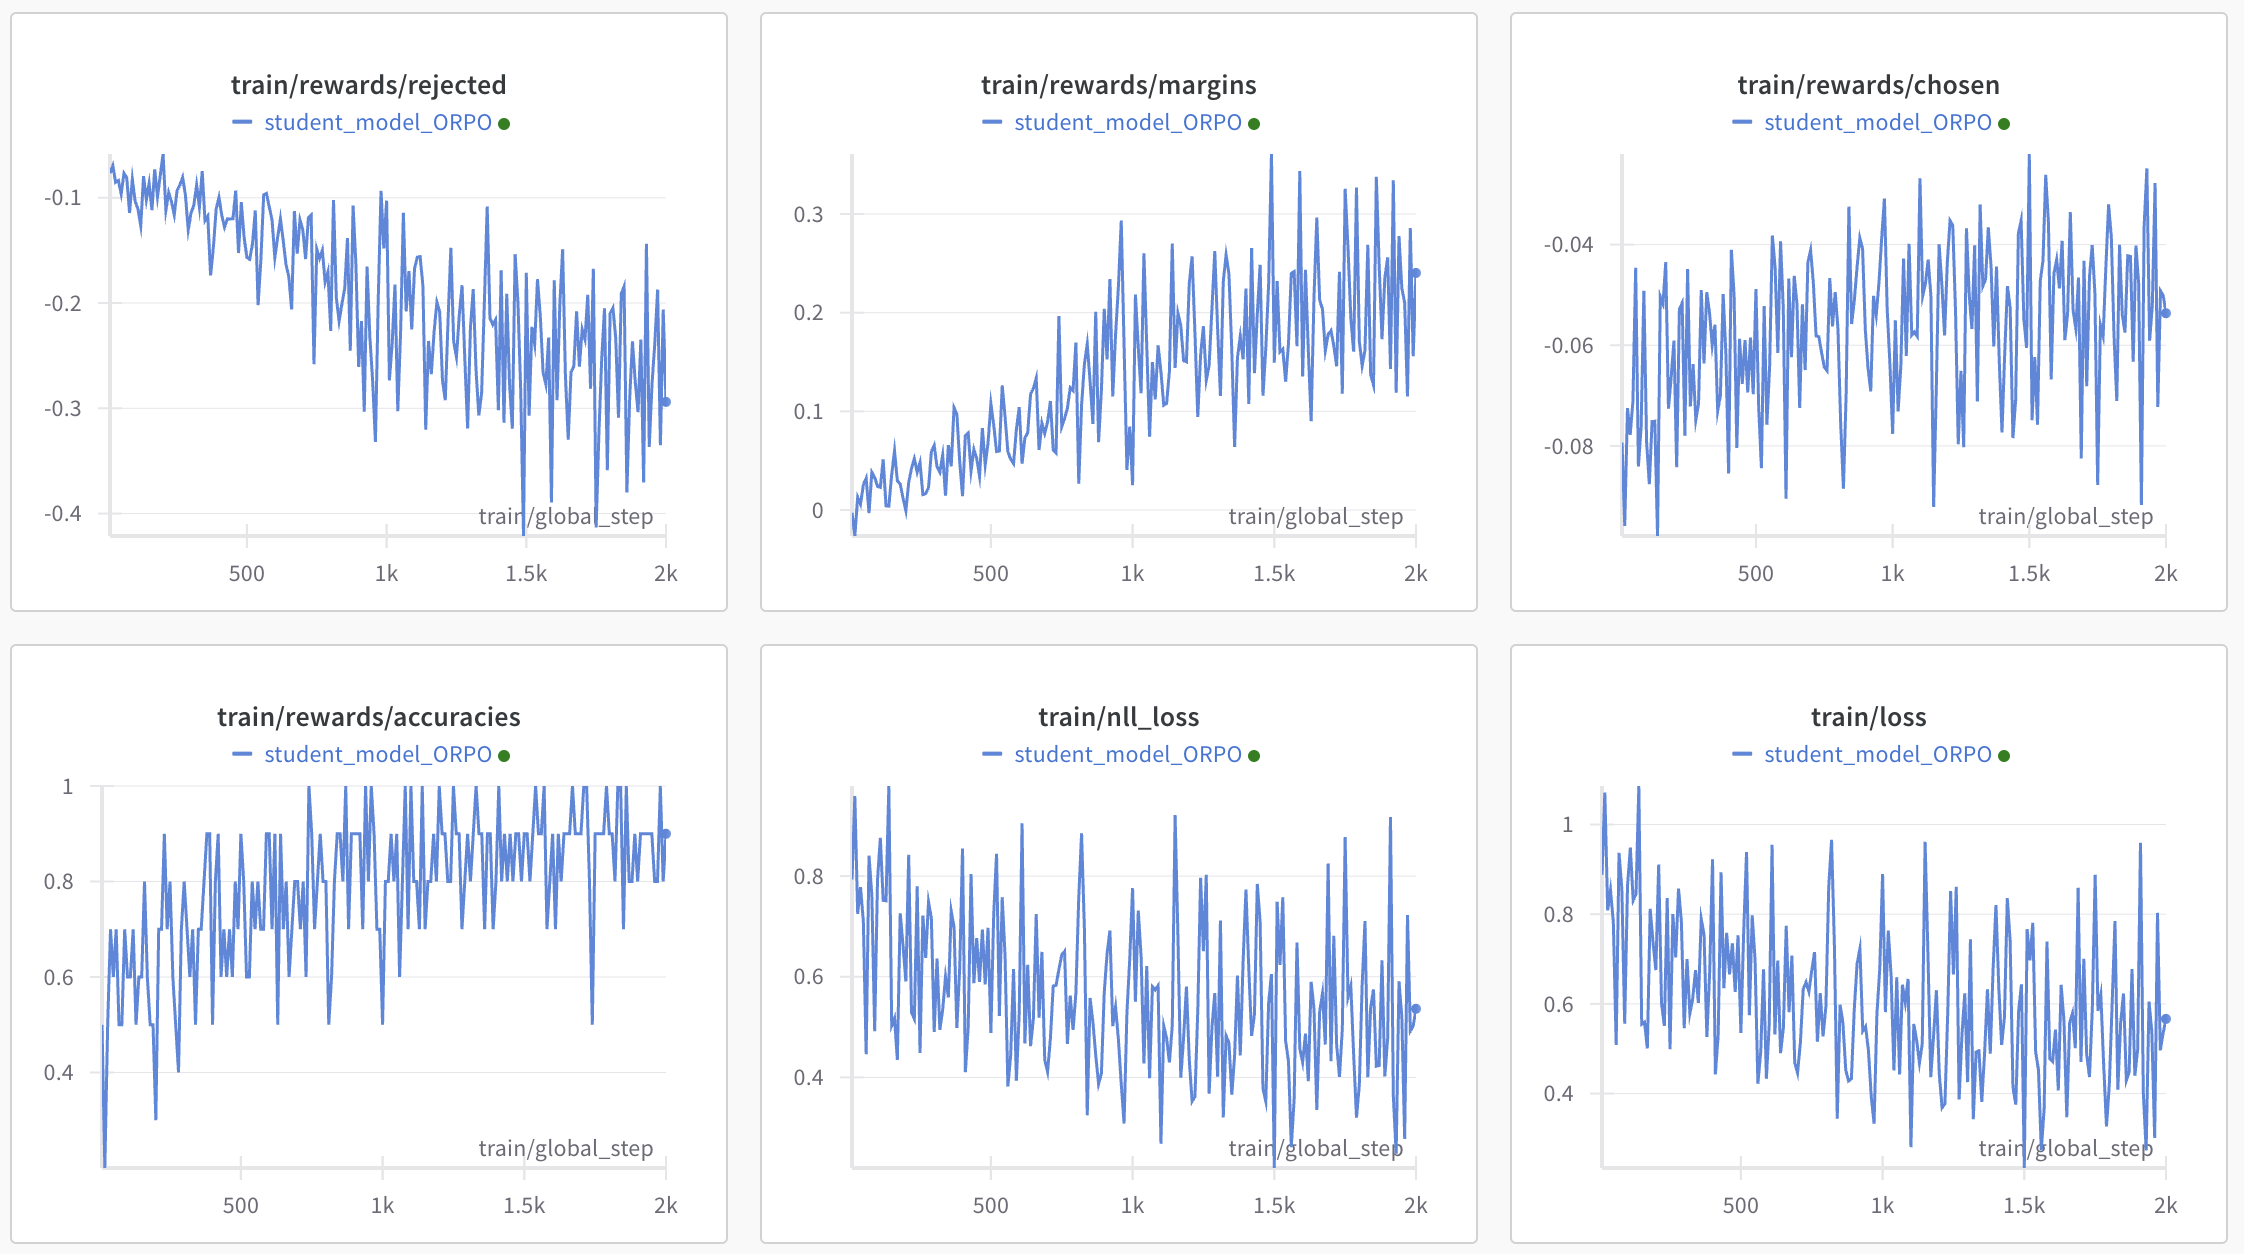

# Results

*   train/loss:0.5665

*   train/nll_loss:0.5363909602165222

*   train/rewards/accuracies:0.8999999761581421


*   train_runtime: 562.0097

*   train/log_odds_chosen: 3.0892157554626465

*   train/log_odds_ratio: -0.3006312847137451